# Download Csv Dataset 

In [2]:
negative_url = 'https://gist.githubusercontent.com/ntakouris/ed4770749887873ebf73c86c66d1bf83/raw/856e89a16f831d523d00841d420177ea3c1354be/negative.csv'
positive_url = 'https://gist.githubusercontent.com/ntakouris/ed4770749887873ebf73c86c66d1bf83/raw/856e89a16f831d523d00841d420177ea3c1354be/positive.csv'

!wget {negative_url} -P /contents 
!wget {positive_url} -P /contents 

--2020-12-29 10:58:49--  https://gist.githubusercontent.com/ntakouris/ed4770749887873ebf73c86c66d1bf83/raw/856e89a16f831d523d00841d420177ea3c1354be/negative.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46831 (46K) [text/plain]
Saving to: ‘/contents/negative.csv.1’

negative.csv.1      100%[===================>]  45.73K  --.-KB/s    in 0.006s  

2020-12-29 10:58:49 (7.18 MB/s) - ‘/contents/negative.csv.1’ saved [46831/46831]

--2020-12-29 10:58:50--  https://gist.githubusercontent.com/ntakouris/ed4770749887873ebf73c86c66d1bf83/raw/856e89a16f831d523d00841d420177ea3c1354be/positive.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.gith

In [3]:
!ls /contents

negative.csv  negative.csv.1  positive.csv  positive.csv.1


# Import Packages and Inspect Dataset

In [4]:
import nltk
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import recall_score, f1_score, precision_score

In [7]:
df_neg = pd.read_csv('/contents/negative.csv')
df_pos = pd.read_csv('/contents/positive.csv')

In [8]:
df_neg.head(10)

,ID,Text,Sentiment
0,N1,I've had an IPhone for like 3 years and I've n...,negative
1,N2,I dont need the new iphone but I want it :(,negative
2,N3,fuck the iPhone 6s cus I'm not getting one :(,negative
3,N4,Hopefully will be able to get my iPhone 6s tod...,negative
4,N5,@clydesdalebank I've just bought a new iPhone ...,negative
5,N6,The new iphone is out today but mine doesn't c...,negative
6,N7,Also have to work an iPhone launch at t-mobile :(,negative
7,N8,@O2 I ended up ringin in my break.. i ordered ...,negative
8,N9,@reviewero iPhone 5 was the best iPhone ever. ...,negative
9,N10,@mitsuhiko scared to update to iOS9 as i don't...,negative


In [9]:
df_pos.head(10)

,ID,Text,Sentiment
0,P1,Who is ready for iPhone 6s and iPhone 6s Plus?...,positive
1,P2,@lucy_larkman there are hacks on how to save h...,positive
2,P3,Hi Rica Cunanan : ricacunanan09 Do u want to g...,positive
3,P4,Hi Ariane Valentine : mainlyboredom Do u want ...,positive
4,P5,Hi eastside_crazii : rthompson672 Do u want to...,positive
5,P6,Hi jayjay : deguzmxnn Do u want to get FREE iP...,positive
6,P7,Hi childish colbino : _Colbae Do u want to ge...,positive
7,P8,Hi ~~~TS~~~ : urminreflection Do u want to get...,positive
8,P9,Hi LBY : AlbyPlays Do u want to get FREE iPhon...,positive
9,P10,Hi angel : pinedo_angel13 Do u want to get FRE...,positive


In [10]:
ds_neg = df_neg['Text'].values
ds_neg = np.stack([ds_neg, np.zeros_like(ds_neg)], axis=1)

ds_pos = df_pos['Text'].values
ds_pos = np.stack([ds_pos, np.ones_like(ds_pos)], axis=1)

# array col 0 is text and col 1 is label (0 for negative, 1 for positive)
ds_neg[0], ds_neg.shape, ds_pos[0], ds_neg.shape

(array(["I've had an IPhone for like 3 years and I've never done that  :( hate ma life",
        0], dtype=object),
 (501, 2),
 array(['Who is ready for iPhone 6s and iPhone 6s Plus? I know I am :)', 1],
       dtype=object),
 (501, 2))

In [11]:
dataset = np.vstack([ds_neg, ds_pos])
dataset.shape

(1002, 2)

# Preprocessing

In [13]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
sentences = dataset[:, 0]
labels = dataset[:, 1].astype('float')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

tokens = []

print('Tokenizing, Stemming, Removing Stopwords')
print()
for i, sentence in enumerate(tqdm(sentences)):
    tokens = word_tokenize(sentence)
    stemmed = [stemmer.stem(x) for x in tokens]
    t = [w for w in stemmed if w not in stop_words]

    sentences[i] = ' '.join(t)
    tokens.append(t)

print()
print('Calculating Tfidf')
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sentences).astype('float')

train_test_limit = int(0.75 * X.shape[0])
X_test = X[train_test_limit:]
X = X[:train_test_limit]

y_test = labels[train_test_limit:]
y = labels[:train_test_limit]

 29%|██▉       | 289/1002 [00:00<00:00, 2888.16it/s]

Tokenizing, Stemming, Removing Stopwords



100%|██████████| 1002/1002 [00:00<00:00, 2340.68it/s]


Calculating Tfidf


# Build and Train Model

In [54]:
def get_model():
    wd = 1e-5
    model = Sequential()
    model.add(Dense(64, input_dim=X.shape[1], activation='relu', kernel_regularizer=regularizers.l2(wd),
                activity_regularizer=regularizers.l2(wd)))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(wd),
                activity_regularizer=regularizers.l2(wd)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['binary_accuracy']) 

    return model

clf = KerasClassifier(build_fn=get_model)
history = clf.fit(X.toarray(), y, validation_data=(X_test.toarray(), y_test), epochs=20, batch_size=32, shuffle=True)

Epoch 1/20
24/24 [==============================] - 1s 13ms/step - loss: 0.6839 - binary_accuracy: 0.6920 - val_loss: 0.7276 - val_binary_accuracy: 0.0000e+00
Epoch 2/20
24/24 [==============================] - 0s 5ms/step - loss: 0.6436 - binary_accuracy: 0.6942 - val_loss: 0.7265 - val_binary_accuracy: 0.5777
Epoch 3/20
24/24 [==============================] - 0s 6ms/step - loss: 0.5934 - binary_accuracy: 0.8469 - val_loss: 0.7103 - val_binary_accuracy: 0.7570
Epoch 4/20
24/24 [==============================] - 0s 6ms/step - loss: 0.5078 - binary_accuracy: 0.9068 - val_loss: 0.6969 - val_binary_accuracy: 0.7570
Epoch 5/20
24/24 [==============================] - 0s 5ms/step - loss: 0.4487 - binary_accuracy: 0.8809 - val_loss: 0.6722 - val_binary_accuracy: 0.7570
Epoch 6/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3615 - binary_accuracy: 0.9124 - val_loss: 0.6360 - val_binary_accuracy: 0.7570
Epoch 7/20
24/24 [==============================] - 0s 6ms/step - loss:

# Result Visualization

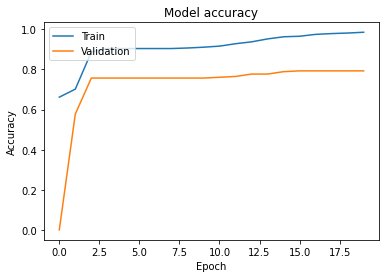

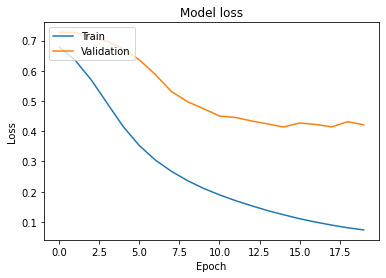

In [55]:
# Plot training & validation binary accuracy values
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()